## Arm Reaching - MI - Sub 20

In [1]:
# !pip install mne

import os
import glob
import numpy as np
import mne
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# from google.colab import drive
# drive.mount('/content/drive')
from scipy.io import loadmat
from scipy.signal import butter, lfilter

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score

from mne.decoding import CSP
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn import tree
from sklearn.multiclass import OneVsRestClassifier,OneVsOneClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

### BrainVision (.vhdr, .vmrk, .eeg)

The BrainVision file format consists of three separate files:

1. A text header file (.vhdr) containing meta data.

2. A text marker file (.vmrk) containing information about events in the data.

3. A binary data file (.eeg) containing the voltage values of the EEG.

In [2]:
# folder_path=r'/content/drive/MyDrive/eeg-raw-data-RM'
folder_path=r'D:\EEG_RawData\EEG_RawData\Arm-Reaching\MI'
folder_files=os.listdir(folder_path)
for i in folder_files:
    print(i)

session1_sub10_reaching_MI.eeg
session1_sub10_reaching_MI.vhdr
session1_sub10_reaching_MI.vmrk
session1_sub11_reaching_MI.eeg
session1_sub11_reaching_MI.vhdr
session1_sub11_reaching_MI.vmrk
session1_sub12_reaching_MI.eeg
session1_sub12_reaching_MI.vhdr
session1_sub12_reaching_MI.vmrk
session1_sub13_reaching_MI.eeg
session1_sub13_reaching_MI.vhdr
session1_sub13_reaching_MI.vmrk
session1_sub14_reaching_MI.eeg
session1_sub14_reaching_MI.vhdr
session1_sub14_reaching_MI.vmrk
session1_sub15_reaching_MI.eeg
session1_sub15_reaching_MI.vhdr
session1_sub15_reaching_MI.vmrk
session1_sub16_reaching_MI.eeg
session1_sub16_reaching_MI.vhdr
session1_sub16_reaching_MI.vmrk
session1_sub17_reaching_MI.eeg
session1_sub17_reaching_MI.vhdr
session1_sub17_reaching_MI.vmrk
session1_sub18_reaching_MI.eeg
session1_sub18_reaching_MI.vhdr
session1_sub18_reaching_MI.vmrk
session1_sub19_reaching_MI.eeg
session1_sub19_reaching_MI.vhdr
session1_sub19_reaching_MI.vmrk
session1_sub1_reaching_MI.eeg
session1_sub1_reachi

In [3]:
sub_20 = []
for file in folder_files:
    if 'sub20' in file:
        sub_20.append(file)
del folder_files
sub_20

['session1_sub20_reaching_MI.eeg',
 'session1_sub20_reaching_MI.vhdr',
 'session1_sub20_reaching_MI.vmrk',
 'session2_sub20_reaching_MI.eeg',
 'session2_sub20_reaching_MI.vhdr',
 'session2_sub20_reaching_MI.vmrk',
 'session3_sub20_reaching_MI.eeg',
 'session3_sub20_reaching_MI.vhdr',
 'session3_sub20_reaching_MI.vmrk']

In [4]:
eeg,vhdr,vmrk = [],[],[]

for i in sub_20:
    file=folder_path+'\\'+i
    if '.eeg' in file:
        eeg.append(file)
    elif '.vhdr' in file:
        vhdr.append(file)
    else:
        vmrk.append(file)

for i in range(0,len(eeg)):
    print(eeg[i]+'\n'+vhdr[i]+'\n'+vmrk[i]+'\n')

D:\EEG_RawData\EEG_RawData\Arm-Reaching\MI\session1_sub20_reaching_MI.eeg
D:\EEG_RawData\EEG_RawData\Arm-Reaching\MI\session1_sub20_reaching_MI.vhdr
D:\EEG_RawData\EEG_RawData\Arm-Reaching\MI\session1_sub20_reaching_MI.vmrk

D:\EEG_RawData\EEG_RawData\Arm-Reaching\MI\session2_sub20_reaching_MI.eeg
D:\EEG_RawData\EEG_RawData\Arm-Reaching\MI\session2_sub20_reaching_MI.vhdr
D:\EEG_RawData\EEG_RawData\Arm-Reaching\MI\session2_sub20_reaching_MI.vmrk

D:\EEG_RawData\EEG_RawData\Arm-Reaching\MI\session3_sub20_reaching_MI.eeg
D:\EEG_RawData\EEG_RawData\Arm-Reaching\MI\session3_sub20_reaching_MI.vhdr
D:\EEG_RawData\EEG_RawData\Arm-Reaching\MI\session3_sub20_reaching_MI.vmrk



### Read Raw Signals

In [5]:
raw_data = []

for file in vhdr:
    raw = mne.io.read_raw_brainvision(file, misc='auto', scale=1.0, preload=True, verbose=None)
    raw_data.append(raw)

raw_data[0] # OR raw_data.info

Extracting parameters from D:\EEG_RawData\EEG_RawData\Arm-Reaching\MI\session1_sub20_reaching_MI.vhdr...
Setting channel info structure...
Reading 0 ... 8597599  =      0.000 ...  3439.040 secs...


Extracting parameters from D:\EEG_RawData\EEG_RawData\Arm-Reaching\MI\session2_sub20_reaching_MI.vhdr...
Setting channel info structure...
Reading 0 ... 9014399  =      0.000 ...  3605.760 secs...
Extracting parameters from D:\EEG_RawData\EEG_RawData\Arm-Reaching\MI\session3_sub20_reaching_MI.vhdr...
Setting channel info structure...
Reading 0 ... 8574399  =      0.000 ...  3429.760 secs...


<RawBrainVision | session1_sub20_reaching_MI.eeg, 71 x 8597600 (3439.0 s), ~4.55 GB, data loaded>

In [6]:
for raw in raw_data:
    raw.set_channel_types(mapping={'hEOG_L': 'eog', 'hEOG_R': 'eog', 'vEOG_U': 'eog', 'vEOG_D': 'eog'})
    raw.set_channel_types(mapping={'EMG_1': 'emg', 'EMG_2': 'emg', 'EMG_3': 'emg', 'EMG_4': 'emg', 'EMG_5': 'emg', 'EMG_6': 'emg', 'EMG_ref': 'emg'})

raw_data[0].info

<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, AF7, AF3, AFz, F7, F5, F3, F1, Fz, FT7, FC5, FC3, FC1, T7, ...
 chs: 60 EEG, 4 EOG, 7 EMG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 1250.0 Hz
 meas_date: 2019-07-31 11:39:11 UTC
 nchan: 71
 projs: []
 sfreq: 2500.0 Hz
>

In [7]:
for raw in raw_data:
    print('bad channels:', raw.info['bads'])  # chs marked "bad" during acquisition
    print(raw.info['sfreq'], 'Hz')            # sampling frequency
    print(raw.info['description'], '\n')      # miscellaneous acquisition info
    print('-' * 40)

bad channels: []
2500.0 Hz
None 

----------------------------------------
bad channels: []
2500.0 Hz
None 

----------------------------------------
bad channels: []
2500.0 Hz
None 

----------------------------------------


Using matplotlib as 2D backend.


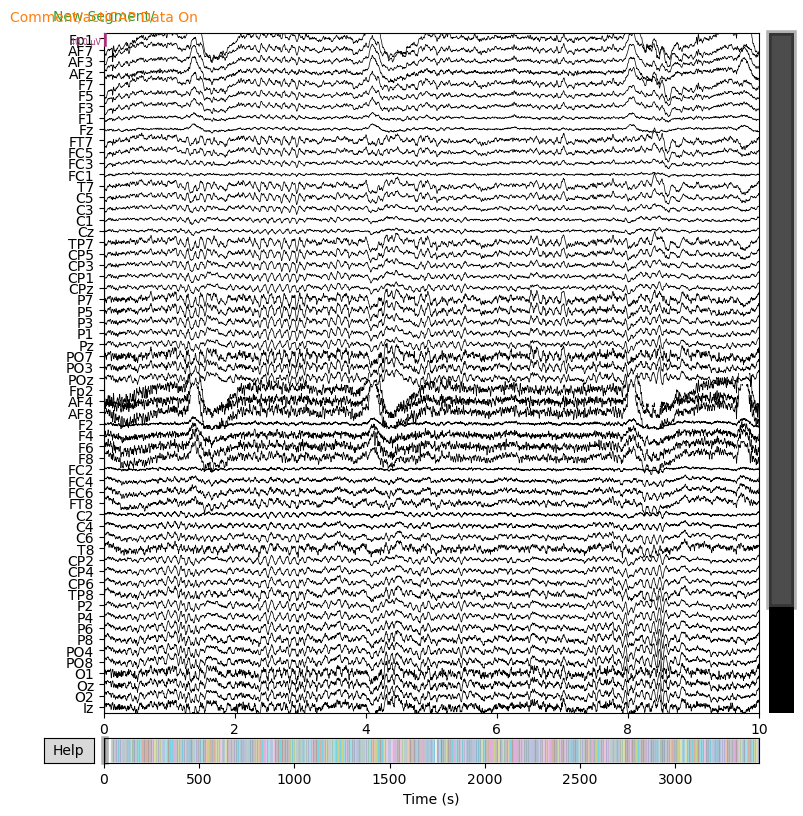

In [8]:
raw_data[0].plot(n_channels=60);  # EEG Channels

### For One Session, Each Subject Do :
 - 50 Trials For Each Class : 50 x 6 ( Classes ) = Total 300 Trials

 - Each Trial has Time Duration 7s ( 3s Visual Cue + 4s Movement Implementation )

 - and There Are 300 Rest Periods Between Those Trials ( Each Rest Period has Time Duration 4s )

 - Finally,
      Total Session Time = 50 x 6 x 7 + 300 x 4 = almost 3300 seconds

In [9]:
for raw in raw_data:
    print('First Time : ',raw.first_time)
    print('Last Time  : ',raw._last_time) 
    print('-' * 40)

First Time :  0.0
Last Time  :  3439.0396
----------------------------------------
First Time :  0.0
Last Time  :  3605.7596
----------------------------------------
First Time :  0.0
Last Time  :  3429.7596
----------------------------------------


- Therefore, The Total Count of Samples For All Trials : 300 ( Trials ) x 7s x 2500 (Fs) + 300 (Rests) x 4s x 2500 (Fs) is almost 8,250,000

In [10]:
for raw in raw_data:
    print('Total Samples : ',len(raw))
    print('Start : ',raw._first_samps)
    print('End : ',raw._last_samps)
    print('-' * 40)

Total Samples :  8597600
Start :  [0]
End :  [8597599]
----------------------------------------
Total Samples :  9014400
Start :  [0]
End :  [9014399]
----------------------------------------
Total Samples :  8574400
Start :  [0]
End :  [8574399]
----------------------------------------


### time_as_index()
- Convert time to indices ( time ( s ) : index ( 0-based ) )

- Input : List of numbers or a number representing points in time.

- Return : Indices relative to first_samp corresponding to the times supplied.

In [11]:
print(raw_data[0].time_as_index([1, 2, 3, 4, 5]), '\n')
print(np.diff(raw_data[0].time_as_index([1, 2, 3])))

[ 2500  5000  7500 10000 12500] 

[2500 2500]


### Electrodes Handling :
### pick_types() : Picking Some Type of Signals and Ignore Others.
### pick_channels() : pick channels by name.
### drop_channels() : method to remove channels by name.

In [12]:
for raw in raw_data:
    raw.pick_types(emg=False, eeg=True, eog=False)
    print(len(raw.ch_names))
    print('-' * 40)

60
----------------------------------------
60
----------------------------------------
60
----------------------------------------


### Bandpass Filtering the Data
- Filtering to remove slow drift.
- Before we run the ICA, an important step is filtering the data to remove low-frequency drifts, which can negatively affect the quality of the ICA fit.

In [13]:
for raw in raw_data:
    raw.filter(l_freq=8, h_freq=30)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 4125 samples (1.650 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 13.1min finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 4125 samples (1.650 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  1.0min finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 4125 samples (1.650 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    5.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  1.7min finished


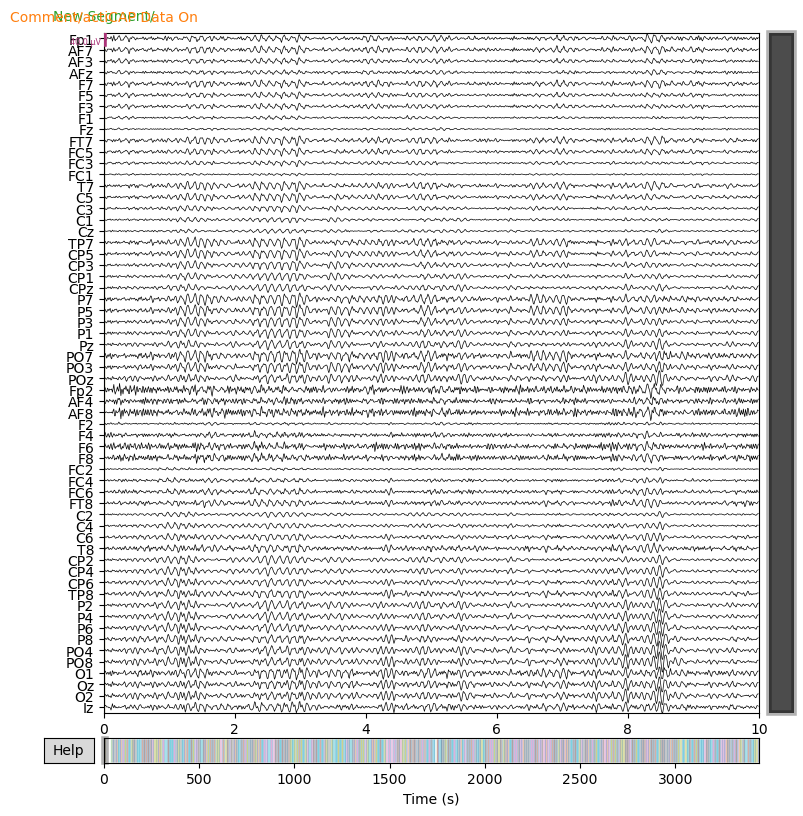

In [14]:
raw_data[0].plot(n_channels=60);

### Refrencing EEG

In [15]:
# Average reference. This is normally added by default, but can also be added explicitly.
for raw in raw_data:
    raw.set_eeg_reference(ref_channels='average')

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


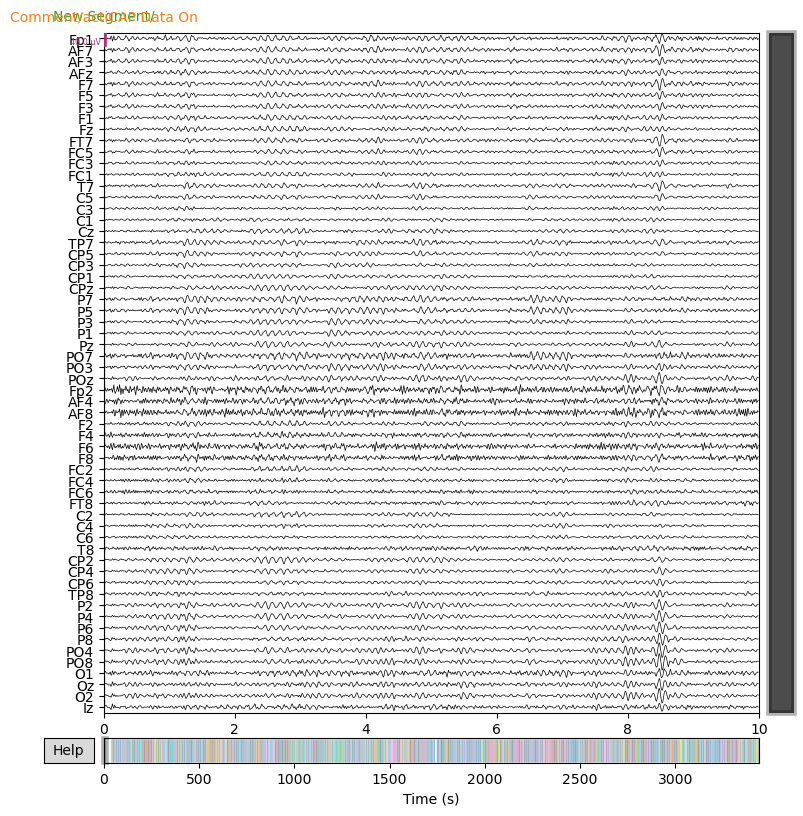

In [16]:
raw_data[0].plot(n_channels=60);

### Read Events & Epoching

In [21]:
events_data = []
for raw in raw_data:
    events = mne.events_from_annotations(raw)
    events_data.append(events)

Used Annotations descriptions: ['Comment/actiCAP Active Shield On', 'Comment/actiCAP Data On', 'New Segment/', 'Stimulus/S  1', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S  6', 'Stimulus/S  8', 'Stimulus/S 11', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 21', 'Stimulus/S 31', 'Stimulus/S 41', 'Stimulus/S 51', 'Stimulus/S 61']


Used Annotations descriptions: ['Comment/ControlBox is not connected via USB', 'Comment/actiCAP USB Power On', 'New Segment/', 'Stimulus/S  1', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S  6', 'Stimulus/S  8', 'Stimulus/S 11', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 21', 'Stimulus/S 31', 'Stimulus/S 41', 'Stimulus/S 51', 'Stimulus/S 61']
Used Annotations descriptions: ['Comment/actiCAP Active Shield On', 'New Segment/', 'Stimulus/S  1', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S  6', 'Stimulus/S  8', 'Stimulus/S 11', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 21', 'Stimulus/S 31', 'Stimulus/S 41', 'Stimulus/S 51', 'Stimulus/S 61']


In [22]:
events_data[0]

(array([[      0,       0,   99999],
        [      0,       0,   10002],
        [  96910,       0,      13],
        ...,
        [8570550,       0,      51],
        [8580585,       0,       8],
        [8585592,       0,      14]]),
 {'Comment/actiCAP Active Shield On': 10001,
  'Comment/actiCAP Data On': 10002,
  'New Segment/': 99999,
  'Stimulus/S  1': 1,
  'Stimulus/S  2': 2,
  'Stimulus/S  3': 3,
  'Stimulus/S  4': 4,
  'Stimulus/S  5': 5,
  'Stimulus/S  6': 6,
  'Stimulus/S  8': 8,
  'Stimulus/S 11': 11,
  'Stimulus/S 13': 13,
  'Stimulus/S 14': 14,
  'Stimulus/S 21': 21,
  'Stimulus/S 31': 31,
  'Stimulus/S 41': 41,
  'Stimulus/S 51': 51,
  'Stimulus/S 61': 61})

In [23]:
selected_data = []
for events in events_data:
    selected_events = mne.pick_events(events[0], exclude=[99999,10001,10002,10003,1,2,3,4,5,6,13,14])
    selected_data.append(selected_events)

del events_data

In [25]:
print(selected_data[0].shape)

(600, 3)


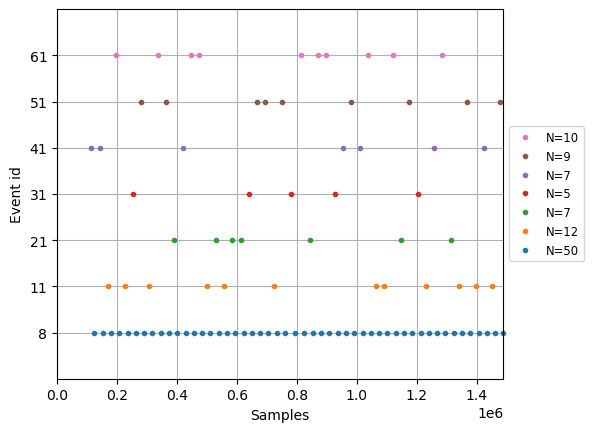

In [26]:
mne.viz.plot_events(selected_data[0][:100]);

In [27]:
event_ids = {'Stimulus/S 11': 11,'Stimulus/S 21': 21,'Stimulus/S 31': 31,'Stimulus/S 41': 41,'Stimulus/S 51': 51,'Stimulus/S 61': 61}

epochs_data = []
for selected_events in selected_data:
    epochs = mne.Epochs(raw, events=selected_events, event_id=event_ids, tmin=0, tmax=7, preload=True,baseline=(0, 0))
    epochs_data.append(epochs)

del selected_data

Not setting metadata
300 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 300 events and 17501 original time points ...


1 bad epochs dropped
Not setting metadata
300 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 300 events and 17501 original time points ...
15 bad epochs dropped
Not setting metadata
300 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 300 events and 17501 original time points ...
0 bad epochs dropped


In [37]:
for epochs in epochs_data:
    print(epochs)
    print(epochs.get_data().shape)
    print('-' * 40)

<Epochs |  299 events (all good), 0 - 7 sec, baseline 0 – 0 sec, ~2.34 GB, data loaded,
 'Stimulus/S 11': 50
 'Stimulus/S 21': 50
 'Stimulus/S 31': 50
 'Stimulus/S 41': 50
 'Stimulus/S 51': 49
 'Stimulus/S 61': 50>
(299, 60, 17501)
----------------------------------------
<Epochs |  285 events (all good), 0 - 7 sec, baseline 0 – 0 sec, ~2.23 GB, data loaded,
 'Stimulus/S 11': 48
 'Stimulus/S 21': 43
 'Stimulus/S 31': 49
 'Stimulus/S 41': 49
 'Stimulus/S 51': 48
 'Stimulus/S 61': 48>
(285, 60, 17501)
----------------------------------------
<Epochs |  300 events (all good), 0 - 7 sec, baseline 0 – 0 sec, ~2.35 GB, data loaded,
 'Stimulus/S 11': 50
 'Stimulus/S 21': 50
 'Stimulus/S 31': 50
 'Stimulus/S 41': 50
 'Stimulus/S 51': 50
 'Stimulus/S 61': 50>
(300, 60, 17501)
----------------------------------------


In [38]:
for epochs in epochs_data:
    epochs.crop(tmin=3,tmax=7,include_tmax=True)

In [39]:
for epochs in epochs_data:
    print(epochs.get_data().shape)

(299, 60, 10001)
(285, 60, 10001)
(300, 60, 10001)


### Epochs Downsampling

In [40]:
for epochs in epochs_data:
    epochs.resample(sfreq=1250)

In [41]:
for epochs in epochs_data:
    print(epochs.get_data().shape)

(299, 60, 5000)
(285, 60, 5000)
(300, 60, 5000)


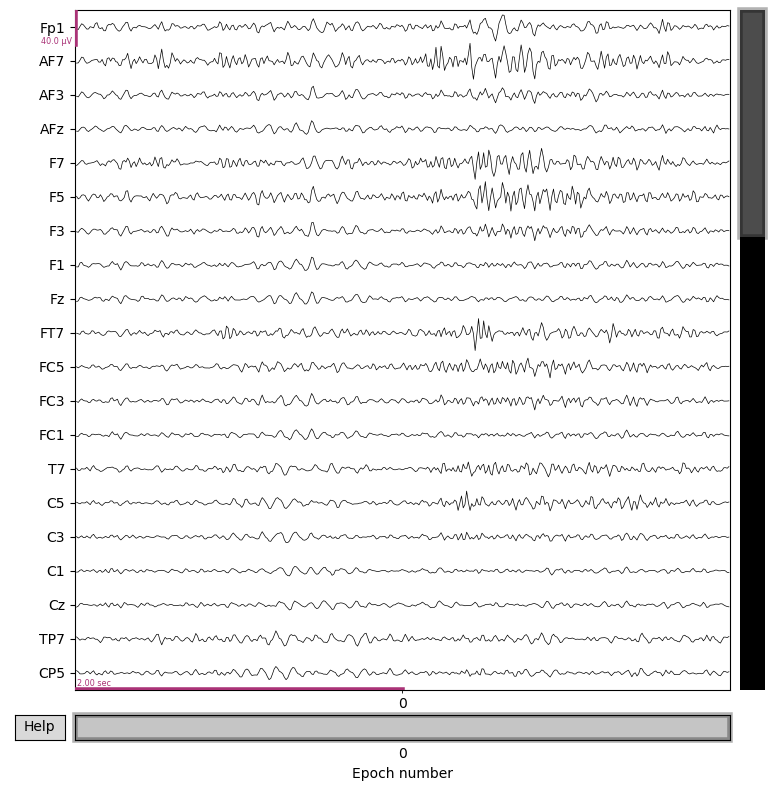

In [42]:
epochs[0].plot(n_epochs=1);

### Merge All Session

In [67]:
decode = {11: 0, 21: 1, 31: 2, 41:3, 51: 4, 61: 5, 8 :6}

data , labels = [] , []

for epochs in epochs_data:
    data_ = epochs.get_data() 
    labels_ = np.empty(shape=(epochs.get_data().shape[0],))
    k=0
    for i in epochs.events:
        labels_[k]=decode[i[2]]
        k+=1
    data.append(data_)
    labels.append(labels_)

In [68]:
data = np.concatenate((data[0], data[1], data[2]), axis=0)
labels = np.concatenate((labels[0], labels[1], labels[2]), axis=0)

In [69]:
data.shape , labels.shape

((884, 60, 5000), (884,))

In [70]:
del raw_data
del epochs_data

## DWT

In [71]:
def preprocess_using_wavelet(filtered_signal):
    import pywt
    from pywt import wavedec ,waverec

    wavelet = 'db4'
    level = 5

    # db8,level 5
    # Daubechies sym7
    coeffs = pywt.wavedec(filtered_signal, wavelet, level=level)

    for i in range(1, level):
        coeffs[i] = np.zeros_like(coeffs[i])

    res = pywt.waverec(coeffs, wavelet)
    return res

In [72]:
dwt_features = preprocess_using_wavelet(data)

In [74]:
plt.plot(dwt_features[0][0])

In [75]:
dwt_features.shape , labels.shape

((884, 60, 5000), (884,))

## Select two classes

In [85]:
count = 0
selected_classes = [0 , 1]
for l in labels:
    if l in selected_classes:
        count+=1
print(count)

291


In [86]:
selected_labels , selected_data = np.empty(shape=(count,)) , np.empty(shape=(count, 60, 5000))
c = 0
for i in range(0, len(labels)):
    if labels[i] in selected_classes:
        selected_labels[c] = labels[i]
        selected_data[c] = dwt_features[i]
        c+=1

In [87]:
c

291

In [88]:
selected_data.shape , selected_labels.shape

((291, 60, 5000), (291,))

## Train-Test Split

In [101]:
# X_train, X_test, y_train, y_test = train_test_split(dwt_features, labels, test_size = 0.2, stratify=labels, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(selected_data, selected_labels, test_size = 0.2,stratify=selected_labels,shuffle=True)

In [102]:
X_train.shape , X_test.shape , y_train.shape , y_test.shape

((232, 60, 5000), (59, 60, 5000), (232,), (59,))

## CSP

In [103]:
csp=mne.decoding.CSP(60)

X_train_csp = csp.fit_transform(X_train,y_train)
X_test_csp = csp.transform(X_test)

Computing rank from data with rank=None
    Using tolerance 0.00021 (2.2e-16 eps * 60 dim * 1.5e+10  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 60 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 60 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00021 (2.2e-16 eps * 60 dim * 1.6e+10  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 60 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 60 -> 59
Estimating covariance using EMPIRICAL
Done.


In [104]:
X_train_csp.shape , X_test_csp.shape

((232, 60), (59, 60))

## Traditional ML Models

## LDA

In [105]:
# ‘svd’, ‘lsqr’, ‘eigen’
lda = LinearDiscriminantAnalysis(solver='svd')
lda.fit(X_train_csp, y_train)

evaluate_train=[X_train_csp, y_train]
evaluate_test=[X_test_csp, y_test]

# model accuracy for svc model

train_accuracy = lda.score(*evaluate_train)
test_accuracy = lda.score(*evaluate_test)
print('train accuracy: ',str(train_accuracy))
print('test accuracy:  ',str(test_accuracy))

train accuracy:  1.0
test accuracy:   0.3898305084745763


In [106]:
# training a linear SVM classifier
from sklearn import svm

# linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’
model = svm.SVC(kernel='sigmoid', degree=10, C=20).fit(X_train_csp, y_train)

evaluate_train=[X_train_csp, y_train]
evaluate_test=[X_test_csp, y_test]

# model accuracy for svc model

train_accuracy = model.score(*evaluate_train)
test_accuracy = model.score(*evaluate_test)
print('train accuracy: ',str(train_accuracy))
print('test accuracy:  ',str(test_accuracy))

train accuracy:  0.9525862068965517
test accuracy:   0.4576271186440678


In [107]:
# training a linear SVM classifier

# kernel: ((...) -> Any) | Literal['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'] = "rbf",
svm_kernel_ovo = OneVsOneClassifier(SVC(kernel='sigmoid', C=10, degree=10, decision_function_shape='ovo')).fit(X_train_csp, y_train)
svm_kernel_ovr = OneVsRestClassifier(SVC(kernel='sigmoid', C=10)).fit(X_train_csp, y_train)

svm_linear_ovo = OneVsOneClassifier(LinearSVC(C=10)).fit(X_train_csp, y_train)
svm_linear_ovr = OneVsRestClassifier(LinearSVC(C=10)).fit(X_train_csp, y_train)

evaluate_train=[X_train_csp, y_train]
evaluate_test=[X_test_csp, y_test]

# model accuracy for svc model
train_accuracy = svm_kernel_ovr.score(*evaluate_train)
test_accuracy = svm_kernel_ovr.score(*evaluate_test)
print('Linear Kernel OneVsRest SVM accuracy: ')
print('          train accuracy: ',str(train_accuracy))
print('          test accuracy:  ',str(test_accuracy))
print('_' * 40)

train_accuracy = svm_kernel_ovo.score(*evaluate_train)
test_accuracy = svm_kernel_ovo.score(*evaluate_test)
print('Linear Kernel OneVsOne SVM accuracy: ')
print('          train accuracy: ',str(train_accuracy))
print('          test accuracy:  ',str(test_accuracy))
print('_' * 40)

train_accuracy = svm_linear_ovr.score(*evaluate_train)
test_accuracy = svm_linear_ovr.score(*evaluate_test)
print('LinearSVC OneVsRest SVM accuracy: ')
print('          train accuracy: ',str(train_accuracy))
print('          test accuracy:  ',str(test_accuracy))
print('_' * 40)

train_accuracy = svm_linear_ovo.score(*evaluate_train)
test_accuracy = svm_linear_ovo.score(*evaluate_test)
print('LinearSVC OneVsOne SVM accuracy: ')
print('          train accuracy: ',str(train_accuracy))
print('          test accuracy:  ',str(test_accuracy))
print('_' * 40)

Linear Kernel OneVsRest SVM accuracy: 
          train accuracy:  0.9655172413793104
          test accuracy:   0.4067796610169492
________________________________________
Linear Kernel OneVsOne SVM accuracy: 
          train accuracy:  0.9655172413793104
          test accuracy:   0.4067796610169492
________________________________________
LinearSVC OneVsRest SVM accuracy: 
          train accuracy:  1.0
          test accuracy:   0.3050847457627119
________________________________________
LinearSVC OneVsOne SVM accuracy: 
          train accuracy:  1.0
          test accuracy:   0.3050847457627119
________________________________________


## AdaBoost

In [108]:
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=150),
                         algorithm="SAMME",
                         n_estimators=100, learning_rate=0.2)
error = []

clf = tree.DecisionTreeClassifier(max_depth=150)
clf.fit(X_train_csp,y_train)
y_prediction = clf.predict(X_test_csp)
accuracy=np.mean(y_prediction == y_test)*100
print ("Decision Tree: " + str(accuracy))

bdt.fit(X_train_csp,y_train)
y_prediction = bdt.predict(X_test_csp)
accuracy=np.mean(y_prediction == y_test)*100
print ("Adaboost: " + str(accuracy))

Decision Tree: 40.67796610169492
Adaboost: 47.45762711864407


## MLP

In [109]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(25), activation='relu')

mlp.fit(X_train_csp, y_train)

print(f"Train Accuracy: {mlp.score(X_train_csp, y_train)*100:.3f}%")
print(f"Test Accuracy: {mlp.score(X_test_csp, y_test)*100:.3f}%")

Train Accuracy: 99.569%
Test Accuracy: 44.068%
